# Introduction to a simple Generative Adversarial Network

## Prerequisites

### Knowledge
- https://towardsdatascience.com/must-read-papers-on-gans-b665bbae3317
- https://github.com/soumith/ganhacks
- https://medium.com/@jonathan_hui/gan-why-it-is-so-hard-to-train-generative-advisory-networks-819a86b3750b
- https://skymind.ai/wiki/generative-adversarial-network-gan
- https://medium.com/@utk.is.here/keep-calm-and-train-a-gan-pitfalls-and-tips-on-training-generative-adversarial-networks-edd529764aa9
- https://medium.com/@jonathan_hui/gan-whats-generative-adversarial-networks-and-its-application-f39ed278ef09
- https://en.wikipedia.org/wiki/Generative_adversarial_network
- https://towardsdatascience.com/leonardo-and-the-gan-dream-f69e8553e0af
- https://arxiv.org/abs/1406.2661
- https://github.com/eriklindernoren/Keras-GAN
- https://wiseodd.github.io/techblog/2016/09/17/gan-tensorflow/

### Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import logging
tf.get_logger().setLevel(logging.ERROR)

import tensorflow_datasets as tfds

### Data

In [2]:
dataset, info = tfds.load('mnist', data_dir='gs://tfds-data/datasets', with_info=True, as_supervised=True)
mnist_train = dataset['train']

def convert_types(image, label):
    image = tf.cast(image, tf.float32)
    image = image / 127.5 - 1.
    return image, label

batch_size = 100
mnist_train = mnist_train.map(convert_types).shuffle(42*batch_size).batch(batch_size)

## Simple GAN for MNIST 

### Generator

In [3]:
def generator(): 
    model = tf.keras.Sequential([tf.keras.layers.Dense(128),
                                 tf.keras.layers.LeakyReLU(alpha=0.01),
                                 tf.keras.layers.Dense(28*28*1, activation='tanh'),
                                 tf.keras.layers.Reshape([28, 28, 1])])
    return model

generator = generator()

### Discriminator

In [4]:
def discriminator():
    model = tf.keras.Sequential([tf.keras.layers.Flatten(),
                                 tf.keras.layers.Dense(128),
                                 tf.keras.layers.LeakyReLU(alpha=0.01),
                                 tf.keras.layers.Dense(1, activation='sigmoid')])
    return model

discriminator = discriminator()

### Training

In [ ]:
generator_opt = tf.keras.optimizers.Adam()
discriminator_opt = tf.keras.optimizers.Adam()

When training the generator, you use

In [ ]:
@tf.function
def train_generator(z_sample, label):
    with tf.GradientTape() as tape:
        image = generator(z_sample)
        prediction = discriminator(image)
        loss = tf.keras.losses.binary_crossentropy(y_true=label, y_pred=prediction)
        # gradient descent and only update generator
        gradients = tape.gradient(loss, generator.trainable_variables)
        discriminator_opt.apply_gradients(zip(gradients, generator.trainable_variables))
    return loss

In [ ]:
@tf.function
def train_discriminator(image, label):
    with tf.GradientTape() as tape:
        # calculate loss
        prediction = discriminator(image)
        loss = tf.keras.losses.binary_crossentropy(y_true=label, y_pred=prediction)
        # gradient descent and only update discriminator
        gradient = tape.gradient(loss, discriminator.trainable_variables)
        discriminator_opt.apply_gradients(zip(gradient, discriminator.trainable_variables))
    accuracy = tf.keras.metrics.binary_accuracy(y_true=label, y_pred=prediction)
    return loss, tf.reduce_mean(accuracy)

In [ ]:
# Labels for real and fake examples
real = np.ones((batch_size, 1), dtype=np.float32)
fake = np.zeros((batch_size, 1), dtype=np.float32)

# init lists for losses and accuracies
losses = []
accuracies = []

# defining the z dimension
z_dim = 100

EPOCHS = 100
for e in range(EPOCHS):
    d_losses, d_accuracies, g_losses = [], [], []
    for image, _ in mnist_train:
        # Generate a batch of fake images
        z_sample = np.random.normal(0, 1, (batch_size, z_dim))
        gen_image = generator(z_sample)
        
        # Discriminator loss and train discriminator on fake and real images
        d_loss_real, d_accuracy_real = train_discriminator(image, real)
        d_loss_fake, d_accuracy_fake = train_discriminator(gen_image, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        d_accuracy = 0.5 * np.add(d_accuracy_real, d_accuracy_fake)

        # Generator loss
        z_sample = np.random.normal(0, 1, (batch_size, z_dim))
        g_loss = train_generator(z_sample, real)
        
        d_losses.append(d_loss)
        d_accuracies.append(d_accuracy)
        g_losses.append(g_loss)
        
    # visualization 
    print("epoch", e, "d_loss", np.mean(d_losses), "g_loss", np.mean(g_losses), "accuracy", np.mean(d_accuracies))    
    losses.append((np.mean(d_losses), np.mean(g_losses)))
    accuracies.append(np.mean(d_accuracies))

epoch 0 d_loss 0.03733677 g_loss 4.891076 accuracy 0.987775000433127
epoch 1 d_loss 0.089473374 g_loss 4.5687647 accuracy 0.9770083430409432
epoch 2 d_loss 0.18231015 g_loss 4.4156957 accuracy 0.9313333391149838
epoch 3 d_loss 0.21286659 g_loss 3.986842 accuracy 0.922391674220562
epoch 4 d_loss 0.21205783 g_loss 4.4282923 accuracy 0.9198000034689904
epoch 5 d_loss 0.15401602 g_loss 4.4744515 accuracy 0.9434333444635074
epoch 6 d_loss 0.17804092 g_loss 4.6332808 accuracy 0.9309416708350181
epoch 7 d_loss 0.19455463 g_loss 4.6442637 accuracy 0.9240083358685176
epoch 8 d_loss 0.2273827 g_loss 4.637403 accuracy 0.9101166650652885
epoch 9 d_loss 0.21056776 g_loss 4.614184 accuracy 0.9161583337187768
epoch 10 d_loss 0.2292985 g_loss 4.234276 accuracy 0.9102666652202607
epoch 11 d_loss 0.2599249 g_loss 4.446496 accuracy 0.8965999987721444
epoch 12 d_loss 0.29464144 g_loss 4.456013 accuracy 0.8838333306709926
epoch 13 d_loss 0.32019958 g_loss 4.15522 accuracy 0.8727916646003723
epoch 14 d_loss

### Visualization

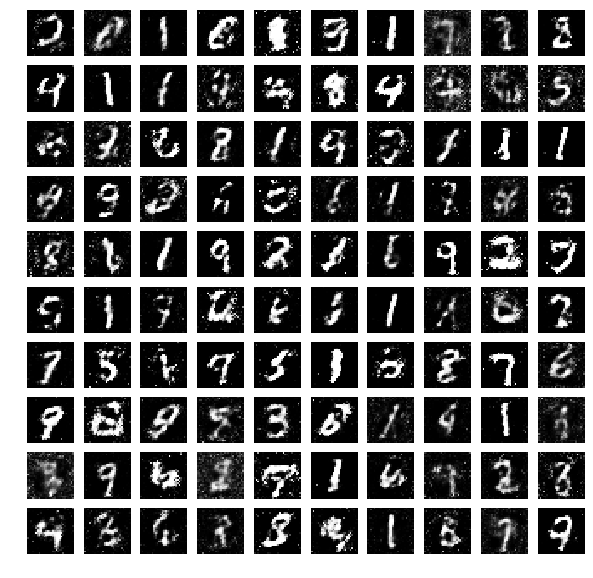

In [9]:
image_grid_rows=10
image_grid_columns=10

# Sample random noise
z_sample = np.random.normal(0, 1, 
          (image_grid_rows * image_grid_columns, z_dim))

# Generate images from random noise 
gen_imgs = generator(z_sample)
# Rescale images to 0-1
gen_imgs = 0.5 * gen_imgs + 0.5

# Set image grid
fig, axs = plt.subplots(image_grid_rows, image_grid_columns, 
                                figsize=(10,10), sharey=True, sharex=True)
cnt = 0
for i in range(image_grid_rows):
    for j in range(image_grid_columns):
        # Output image grid
        axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
        axs[i,j].axis('off')
        cnt += 1

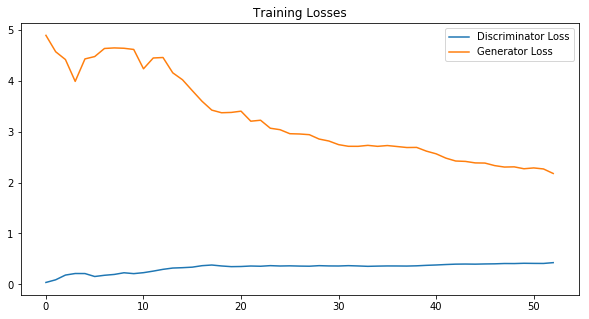

In [10]:
losses = np.array(losses)

# Plot training losses for Discriminator and Generator
plt.figure(figsize=(10,5))
plt.plot(losses.T[0], label="Discriminator Loss")
plt.plot(losses.T[1], label="Generator Loss")
plt.title("Training Losses")
plt.legend()

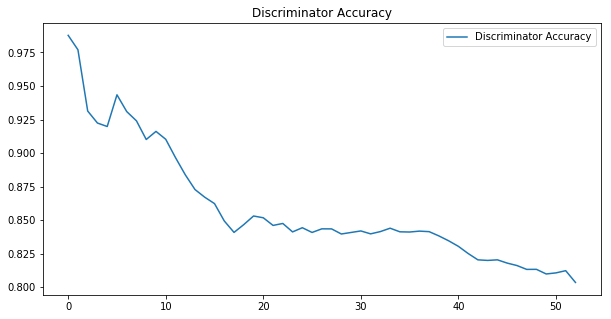

In [11]:
accuracies = np.array(accuracies)

# Plot Discriminator accuracy
plt.figure(figsize=(10,5))
plt.plot(accuracies, label="Discriminator Accuracy")
plt.title("Discriminator Accuracy")
plt.legend()